**Please trust the notebook to view the visualizations.**

# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B: Advanced Topics in Data Science 

##  Measuring the Shape and Brightness of Galaxies with Neural Networks

### Group 75: Dmitry Vukolov, Ning Xu, Rohit Beri, Sunil Chomal


**Harvard University, Spring 2020**<br/>
**Instructors**: Pavlos Protopapas, Mark Glickman and Chris Tanner<br/>
**Project Advisors**: Douglas Finkbeiner and Jun Yin<br/>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import tensorflow as tf

assert tf.__version__ >= "2.1.0", "TF 2.1 is required to run this notebook"

# Load plotting and helper functions
%run plotting.ipynb
%run autoencoder.ipynb
%run xception.ipynb

# Set to True to retrain the models
train = False

In [2]:
# Configure matplotlib format, dimensions and styling
%config InlineBackend.figure_formats = ['retina']
plt.rc("figure", figsize=(7, 3.5))
sns.set(style="white", palette=None, rc={"axes.linewidth": 1})
plt.rc("image", cmap="viridis")

# Outline

1. Problem Statement
2. Data Generation
3. Exploratory Data Analysis
4. Model Building
5. Evaluation
6. Future Work
7. References

---

# Problem Statement

**Vast amounts of data:** As astronomers collect more and more image data, there is a need for further development of automated, reliable, and fast analysis methods.

**Traditional methods:** For example, to describe a galaxy, software is used to fit a parametric or a non-parametric model and estimate the galaxy's brightness, shape, size, and orientation. A commonly used, though not a perfect model, is the [Sérsic profile](https://en.wikipedia.org/wiki/Sérsic_profile), developed in 1963.

**New methods:** In recent years, researchers have started exploring the application of deep learning methods to analyze astronomical data. For instance, classification of galaxies using CNNs has demonstrated high levels of accuracy. In this work, we study the possibility to use neural networks to estimate galaxy parameters from simulated data.

Our **objective**: *Explore deep neural network architectures to estimate galaxy parameters from simulated data.*

---

# Data Generation

We use [GalSim](https://github.com/GalSim-developers/GalSim), an open-source library, to generate the images of galaxies, following these steps:

1. **Sérsic profile:** Define a galaxy's Sérsic profile parametrized by the Sérsic index and the radius that encloses half of the total flux
2. **Flux & shear:** Add flux and shear (defined by ellipticity and orientation) to complete the galaxy definition
3. **PSF:** Convolve the galaxy profile with the Point Spread Function, which is determined by the telescope optics and the atmosphere (for ground-based telescopes).
4. **Noise:** Add Poisson noise (e.g. detected photoelectrons) and Gaussian noise (e.g. read noise) to the generated the image
5. **Signal-to-noise ratio:** Compute the signal-to-noise ratio (SNR) based on the pixel values and the noise level (assuming faint galaxies):
$$
SNR = \frac{1}{\sigma_p} \sqrt{\sum p_i^2}
$$
   We preserve only the images with SNR between 10 and 100.
   

### Datasets
We generate three datasets with increasing complexity for parameter estimation:
  
| Dataset | Number of Samples | PSF             | Gaussian Noise Level | Signal-to-Noise Ratio |
| ------- | ----------------- | --------------- | -------------------- | --------------------- |
| 1.      | 200,000           | 0.5             | 200                  | From 10 to 100        |
| 2.      | 200,000           | 0.5             | From 200 to 400      | From 10 to 100        |
| 3.      | 200,000           | From 0.5 to 1.0 | From 200 to 400      | From 10 to 100        |
  
**Number of samples:** We simulate 200,000 observations in total, using 180,000 samples for training and 20,000 for validation. Our choice to generate a large number of samples is driven by literature review, e.g. [Tuccillo, 2017](https://arxiv.org/pdf/1711.03108) and [Madireddy, 2019](https://arxiv.org/pdf/1911.03867), who are using 55,000 and 120,000 images respectively and suggest scaling up to 1 million. Our subsequent observations confirm that even on synthetic data, model performance improves as we add more data.

**Discretization:** One major challenge in simulating a large number of observations has to do with GalSim, which is relatively slow especially when generating images with higher Sérsic indices. The developers of GalSim [recommend](http://galsim-developers.github.io/GalSim/_build/html/gal.html#Sérsic-profile) considering the use of only discrete values of the Sérsic index for large simulations. This takes advantage of internal caching mechanisms and speeds up generation considerably. We follow that advice, discretize Sérsic index into 1,000 equally spaced values, and [increase GalSim's cache size](https://github.com/dvukolov/GalSim/tree/sersic-cache). This cuts down CPU time for data generation from approximately 90 hours to 1.2 hours per dataset.

### Target variables
Our goal is to estimate the following five parameters from image data, which are recorded alongside the generated images:

- Sérsic profile: determined by the **Sérsic index** and the **Sérsic radius**
- Galaxy **flux**
- Reparameterized **ellipticity and orientation**: $g_1$ and $g_2$

**Source code:** The code for data generation is based on the template provided by the module leaders and is available in the [GitHub repo](https://github.com/dvukolov/cs109b-project/blob/master/data/generator.py).

---

# Exploratory Data Analysis

**Milestone 2 EDA:** The majority of EDA has been carried out for Project Milestone 2 and is available in the corresponding EDA.ipynb notebook. We avoid repeating the analysis in the current report and instead refer the reader to the original document. Here we present only the findings that informed our model building approach. 

**Interactive app:** As part of the analysis we created an interactive [web app](https://measure-galaxies.herokuapp.com/) that laid the foundation for understanding the data. We used it throughout our project to study the relationship between galaxy parameters and the resulting images. It also helped us identify which parameter combinations could present a particular issue for the model versus which would be relatively easier to estimate.

![screencast](graphs/screencast.gif)

## Key Findings

The noisy images of the galaxies are characterized by three different aspects:
- The galaxy itself, independent of an observer. Sérsic index, Sérsic radius, flux, and shear are some of its parameters.
- The observational distortion determined by the telescope specification and the state of the atmosphere. The Point spread function (PSF) is used to encode this information.
- Contributions of noise, which can include Poisson statistics of detected photoelectrons and Gaussian noise such as read noise.

These are independent of each other, however, the final image is affected by each of these. We need to train a network to "deconvolve" these aspects and predict the parameters.

## Considerations for Model Building

The knowledge of the data-generating procedure, together with the EDA informed our subsequent model building as follows:

- The **Sérsic index** is **quite difficult to estimate** visually making it an important parameter when doing model selection.
- The **target variables** need to be **rescaled** so that the loss is not driven by the variables with the largest magnitude.
- The **simulated images** form a perfect dataset, free of outliers and irregularities, with underlying deterministic relationships between a handful of parameters. **Smaller neural networks** might be capable of capturing the underlying dependencies in the data, and regularization might turn out to be optional.
- The **PSF** and **noise** levels **have a significant effect** on the obtained images. Where possible, they should be used as inputs to the model. 
- To understand how dramatic the effect of the noise is, we might want to establish an **upper bound** on model performance by training on the noiseless images first.
- Given the availability of noiseless images, models that take advantage of this additional information should be explored.

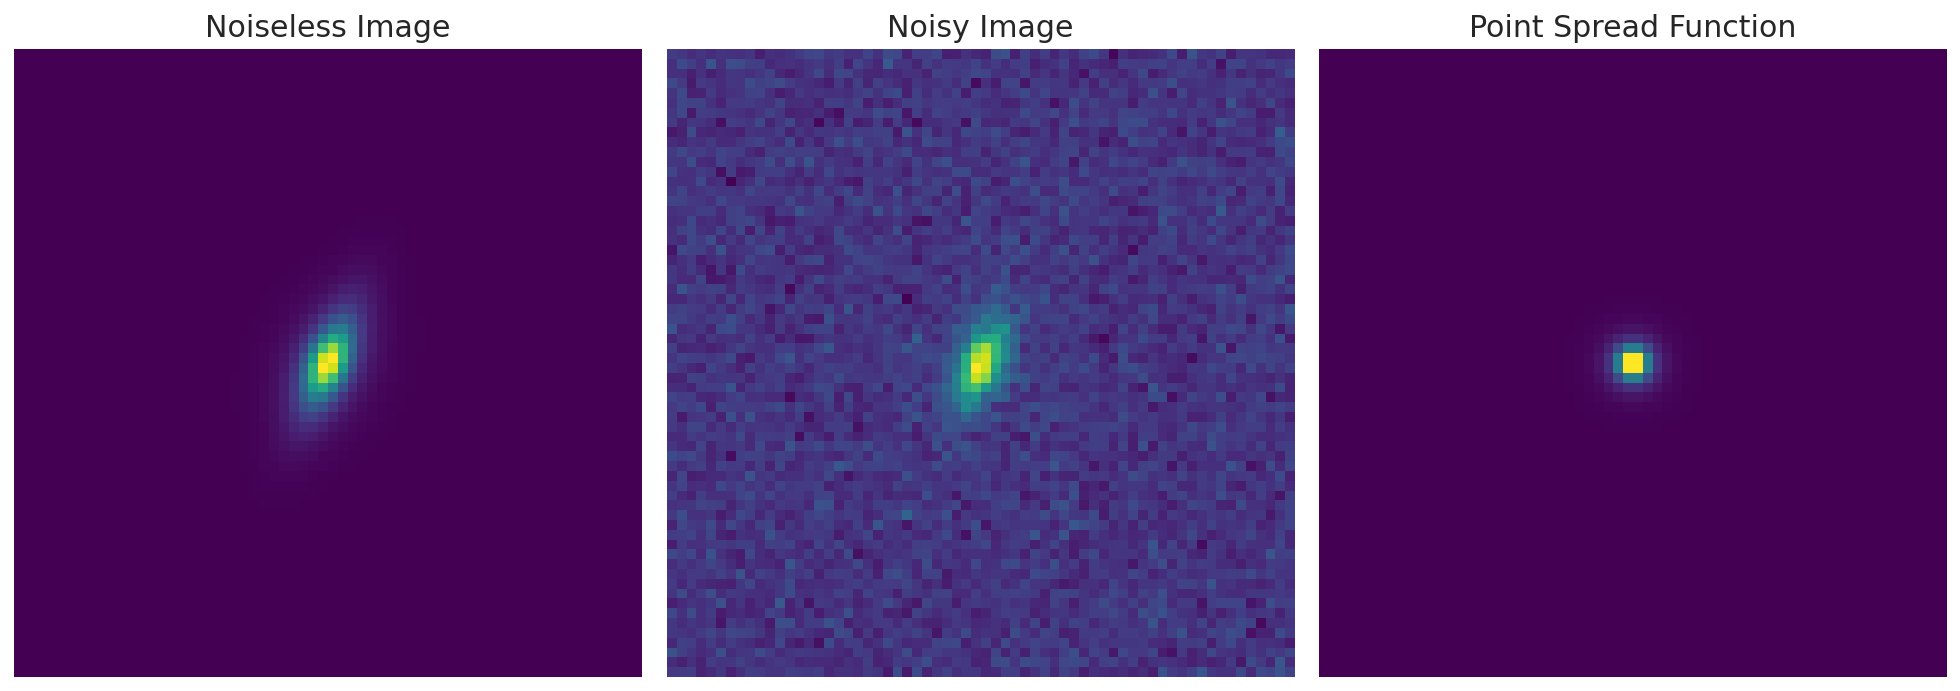

In [3]:
# Load the data with fixed PSF=0.5 and varying nose levels
dataset = "../data/data_v2.npz"
with np.load(dataset) as data:
    img = data["img"]
    img_nonoise = data["img_nonoise"]
    psf_img = data["psf_img"]
    label = data["label"]
    snr = data["snr"]

# Visualize one observation
idx = 3
images = img_nonoise[idx], img[idx], psf_img[0]
titles = ["Noiseless Image", "Noisy Image", "Point Spread Function"]

fig, axes = plt.subplots(1, 3, figsize=(13.5, 5), constrained_layout=True)
for image, title, ax in zip(images, titles, axes):
    ax.imshow(image)
    ax.axis("off")
    ax.set_title(title, fontsize=15)

---

# Model Building

In our model building we used multiple approaches:

### Autoencoders

An autoencoder has two potential advantages:

- First, an autoencoder is learning from both the labels and the noiseless images and thereby might incorporate more information about the underlying relationships into the network.
- Secondly, an autoencoder can be used not only to predict the labels but also to denoise and reconstruct the images.

Furthermore, we take inspiration from Jun Yin's work with Conditional Autoencoders mentioned during the lectures.
- We experiment with several possibly related architectures.
- We begin by trying to replicate GalSim output through building a decoder first — clean images are a deterministic function of the labels.
- Then we invert the decoder architecture to build a basic encoder structure.

### Neural architecture search

<img style="float: right; padding-left: 10px; padding-bottom: 20px;" src="https://autokeras.com/img/row_red.svg" width="200" />Using a small subset of the data we run [AutoKeras](https://autokeras.com/), an AutoML tool, to quickly test vanilla CNNs, ResNets, and Xception networks with different complexities, regularization, and normalization parameters. The search is guided by Bayesian optimization with Gaussian Processes.

### Grid search of hyperparameters
- We pick several key hyperparameters of the best model, expand their range, and evaluate the effect using a small portion of the data.
- This allows us to significantly reduce the model size, decrease the training time, while simultaneously maintaining or even improving predictive performance.

### Denoising pipeline

Informed by a large gap between performance metrics for noiseless and noisy data, we test a two-stage pipeline described in [Madireddy (2019)](https://arxiv.org/pdf/1911.03867) that uses a separate denoising network as the first step. 

---

# Autoencoder

The initial idea of using an autoencoder for the task occurred to us during the EDA stage. We recognized that the dataset available to us has both the parameters and the noiseless image. An autoencoder can make use of both to train a network and predict them at the same time. An autoencoder can thus solve two problems simultaneously and may provide more robustness to the model. We were further inspired by Jun Yin's comments about using a Conditional Autoencoder with parameters representing the latent space.

## Decoder
We know that the simulated noiseless images generated by GalSim are a deterministic function of five parameters plus the PSF. As the first step, we looked for an architecture of the Decoder which can take 5 parameters as input and output an image of the galaxy, i.e. learn the GalSim deterministic function via a deep CNN architecture. Our reasoning behind this being that if we can figure out a network to generate correct images from the labels, inverting the same architecture may let us do the reverse, i.e. generate the parameters from a noiseless image. If we have such an encoder, we can then look at suitably modifying the same to generate the parameters from the noisy image as well. During this exercise we explored the following aspects:
* Normalizing the parameters (`inputs`)
    - Since the parameters are on different scales, particularly the `Flux`, we normalize all to $[0,1]$.
* Normalizing the noiseless images (`output`)
    - After experimenting with individual image level normalization and training set level normalization, we chose the latter, as it produces better results.
* We modify the `ConvDecoder` layer used in our `DCGAN` assignment
    - Increase the number of `Conv2D` layers to six.
    - Change the activation function to `LeakyReLU`, except for the last layer where we use `sigmoid` because of the $[0,1]$ normalization of the images.
    - We also investigate different striding and in the end choose a stride of $(2,2)$ .
    - Using `Dropout` with `Conv2D` reduces the effectiveness of the `ConvDecoder` and hence we set the dropout rate to $0$.
    
* We also experiment with the number of `Dense` layers and ultimately use two `Dense` layers
    - We use `linear` activation for the first layer and `LeakyRelu` for the second layer.
    - The reason for the first linear activation is to maximize the information captured from the input layer.
    - We use `Dropout` layers with a dropout rate of $0.50$ after both `Dense` layers.

* We use `BinaryCrossentropy` as our loss function
    - The last layer of our network uses `sigmoid` activation function to align with the $[0,1]$ normalization of the images.
    - We empirically found binary cross-entropy to work better compared to `MSE` on our dataset. Our hypothesis is that might be either due to the distribution of pixel values that are close to either 0 or 1, or due to a less pronounced vanishing gradient problem.

### <center>Our final decoder architecture</center>
<img src="./graphs/Decoder.png" width="300px">

## Encoder
As the first step towards building the encoder, we reverse the decoder architecture above as follows:

* Normalize the noiseless images and parameters similar to the decoder above
* The `ConvDecoder` layer is replaced by `ConvEncoder` from our `DCGAN` assignment. 
    - `Conv2D` layers are replaced with `Conv2DTranspose` layers with a stride of $(2,2)$ 
    - All of the layers use `LeakyReLU` activation 
    - The dropout rate is set to $0$
* The output `Dense` layer uses `sigmoid` activation and the `Dense` layer immediately preceding it uses `linear` activation 
    - We use `Dropout` layers with a dropout rate of $0.50$ after the intermediate `Dense` layers.
* Again use `BinaryCrossentropy` as our loss function together with `sigmoid` activation of the final layer

The above architecture produces good results on noiseless images, so we proceed to train the same on the noisy dataset. After multiple experiments with different datasets, additional inputs, batch level normalization, additional image preprocessing (as recommended by Jun Yin during the office hours), we make the following modifications to our architecture:
* We do away with the normalization of the input images and resort to a `BatchNormalization` layer in the encoder
* We learn that Sigma & PSF can be independently computed and hence are available as inputs
* Image input is now a 7-channel input layer with these channels:
    1. Original Noisy Image: $I$
    2. Noisy Image divided by Sigma ($\sigma$), the level of Gaussian noise of the image: $\frac{I}{\sigma}$
    3. Squared Noisy Image divided by $1.41$ times Sigma squared: $\frac{I^{2}}{1.41\sigma^{2}}$
    4. Noisy Image divided by the Variance of pixel values of the image: $\frac{I}{\sigma_p^{2}}$
    5. Noisy Image divided by the product of the Squared Variance and Sigma: $\frac{I}{\sigma_p^{4}.\sigma}$
    6. PSF Image: $P$
    7. PSF Squared Image: $P^{2}$
* Apart from the image input layer, we add a secondary input layer as follows:
    1. Sigma ($\sigma$), the Gaussian noise level of the image
    2. The PSF value for the full-width-half-max of the Moffat profile ($\text{psf}_r$)
    3. Standard Deviation ($\sigma_p$) of pixel values of the image
    4. Mean ($\mu_p$) of pixel values of the image

### <center>Our final encoder architecture</center>
<img src="./graphs/Encoder.png" width="715px">

## Model Parameters

Type of Parameters      |Encoder       | Decoder      | **Auto-encoder**
------------------------|--------------|--------------|-----------------
Trainable Parameters    |17,316,827    |13,110,529    |30,427,356
Non-trainable Parameters|22            |0             |22
**Total**               |**17,316,827**|**13,110,529**|**30,427,378**

---

# Autoencoder: Training

## Training Process
Our training process is **divided into $3 \times 3$ parts: $3$ datasets times $3$ steps.** For each dataset, we follow these steps:
1. Train the Encoder
2. Train the Decoder
3. Train the Autoencodder to fine-tune the weights

We find that $3$-step training achieves better results than training the Autoencoder in one go.

## Training Hyper-parameters

Description                  |Encoder           |Decoder           |Autoencoder
-----------------------------|------------------|------------------|------------------
**Loss Function**            |BinaryCrossentropy|BinaryCrossentropy|BinaryCrossentropy
**Optimizer**                |Adam              |Adam              |Adam
**Learning Rate**            |0.001             |0.001             |Scheduler
**Max Epoch**                |50                |50                |50
**Actual Epochs**            |20                |17                |37
**Early Stopping**           |5                 |5                 |5
**Loss Weights**             |                  |                  |
 - Encoder                   |1                 |0                 |5
 - Decoder                   |0                 |1                 |1
**Training Set**             |180,000           |180,000           |180,000
**Validation Set**           |20,000            |20,000            |20,000
**Trained on**               |                  |                  |
 - fixed Sigma & fixed PSF   |Y                 |Y                 |Y
 - variable Sigma & fixed PSF|Y                 |Y                 |Y
 - variable Sigma & fixed PSF|Y                 |Y                 |Y
 
## Training Time

Description                        |Encoder           |Decoder           |Autoencoder       |Total
-----------------------------------|------------------|------------------|------------------|-----------
**Training time per Epoch**        |170 seconds       |140 seconds       |330 seconds       |11 minutes
**Total training time per dataset**|57 minutes        |40 minutes        |203 minutes       |5 hours
**Total training time**            |170 minutes       |120 minutes       |605 minutes       |15 hours
**Estimation time per observation**| < 0.5 ms         |< 0.5 ms          |< 0.8 ms        |< 0.8 ms


## Validation Results

### Dataset 1: Fixed Gaussian Noise Level and Fixed PSF 
    
Parameter    |Bias  |RMSE |Unexplained Variance |Explained Variance
-------------|------|-----|---------------------|------------------
Flux         |-3010 |7800 |	0.03                |	0.97
Sersic Index |-0.076|0.798|	0.25                |	0.75
Sersic Radius|0.002 |0.049|	0.12                |	0.88
g1           |0.016 |0.083|	0.09                |	0.91
g2           |0.006 |0.076|	0.07                |	0.93

### Dataset 2: Varying Gaussian Noise Level and Fixed PSF 
    
Parameter    |Bias  |RMSE |Unexplained Variance |Explained Variance
-------------|------|-----|---------------------|------------------
Flux         |-2991 |12055|0.02                 |	0.98
Sersic Index |0.177 |0.872|0.30                 |	0.70
Sersic Radius|0.000 |0.052|0.14                 |	0.86
g1           |-0.001|0.087|0.10                 |	0.90
g2           |0.014 |0.086|0.09                 |	0.91

### Dataset 3: Varying Gaussian Noise Level and Varying PSF 
    
Parameter    |Bias  |RMSE |Unexplained Variance |Explained Variance
-------------|------|-----|---------------------|------------------
Flux         |-4450 |14512|0.02                 |	0.98
Sersic Index |-0.070|1.012|0.40                 |	0.60
Sersic Radius|-0.008|0.057|0.16                 |	0.84
g1           |0.010 |0.111|0.16                 |	0.84
g2           |-0.005|0.108|0.15                 |	0.85

## Autoencoder: Source Code

The notebook detailing the training process and the code can be found in a supplemental notebook named **autoencoder_training.ipynb**, submitted as part of this project.

---

# Neural Architecture Search

We perform the initial neural architecture search with the help of AutoKeras, an AutoML tool from the Keras team. On a small subset of the data:

- We test different **type of architectures**: regular CNNs, ResNets, and Xception models
- Vary the **specifics of the architectures**: depth and the width of the network, the convolutional kernel size, striding, type of pooling, different activation functions
- We test whether data **normalization** and **dropout** regularization are necessary
- As well as briefly check the effect of three **optimizers**: Adam, Adagrad, and SGD

Our hypothesis is that due to the simulated and homogeneous nature of the dataset, the performance on a small subset will be indicative of the performance on the full dataset.

In [4]:
import json
import autokeras as ak
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping

# Use unscaled images. Let Autokeras figure out if normalization is needed.
subset = 20_000
X = img[:subset]

# Scale the labels between -1 and 1 using the full dataset, since we know the ranges of generated labels.
scaler = MinMaxScaler(feature_range=(-1, 1))
y = scaler.fit_transform(label[:subset])

json_path = "../experiments/autokeras/noisy_params.json"
if train:
    # Define and train an AutoKeras model
    early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

    input_node = ak.ImageInput()
    output_node = ak.ImageBlock(augment=False)(input_node)
    output_node = ak.RegressionHead()(output_node)
    auto = ak.AutoModel(inputs=input_node, outputs=output_node, max_trials=100, tuner="bayesian")
    auto.fit(X, y, epochs=100, validation_split=0.2, verbose=2, callbacks=[early_stopping])

    # Instantiate the best model
    model = auto.export_model()

    # Save the best hyperparameters
    hp = auto.tuner.get_best_hyperparameters()[0]
    params = hp.get_config()["values"]
    with open(path, "wt") as f:
        json.dump(params, f, indent=2)

The output of the search demonstrates that:

- **ResNets** perform significantly worse on our data compared to **regular CNNs** and **Xception** models
- Normalization and specifically **standardization** of the images to zero mean and standard deviation of one is beneficial
- **Dropout** is generally unnecessary, as it negatively impacts predictive performance and increases the training time
- **Adam** converges faster than the alternative optimizers and produces the lowest mean-squared error

The resulting best model chosen by AutoKeras has [Xception](https://arxiv.org/pdf/1610.02357.pdf) architecture with 18 depthwise separable convolutional layers, 8 residual connections, 16 convolutional filters in the entry flow, 384 filters in the separable convolutions, a kernel size of 5, selu activation and global average pooling.

In [5]:
# Display the set of best hyperparameters chosen by AutoKeras
with open(json_path) as f:
    configuration = json.load(f)
pd.Series(configuration)

image_block_1/xception_block_1/activation             selu
image_block_1/xception_block_1/initial_strides           2
image_block_1/xception_block_1/num_residual_blocks       8
image_block_1/xception_block_1/pooling                 avg
image_block_1/xception_block_1/conv2d_num_filters       16
image_block_1/xception_block_1/kernel_size               5
image_block_1/xception_block_1/sep_num_filters         384
regression_head_1/dropout_rate                           0
optimizer                                             adam
dtype: object

We implement this architecture in code and instantiate the model:

In [6]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from kerastuner.applications import xception


def build_xception_model(
    input_shape,
    output_shape,
    normalize=True,
    conv2d_num_filters=64,
    kernel_size=5,
    initial_strides=2,
    activation="selu",
    sep_num_filters=256,
    num_residual_blocks=4,
    pooling="avg",
    dropout_rate=0,
):
    """Build an image regression model with Xception blocks.
    Original architecture by François Chollet https://arxiv.org/pdf/1610.02357.pdf
    Code based on Autokeras and Keras Tuner.
    """

    assert len(input_shape) == 3, "The input images should have a channel dimension"
    assert activation in ["relu", "selu"]
    assert pooling in ["avg", "flatten", "max"]

    inputs = layers.Input(shape=input_shape)
    x = inputs

    if normalize:
        # Compute the mean and the variance of the dataset and store it as model weights.
        # Don't forget to use adapt_model(model, X) before fitting the model.
        x = preprocessing.Normalization()(x)

    # Initial conv2d
    x = xception.conv(
        x, conv2d_num_filters, kernel_size=kernel_size, activation=activation, strides=initial_strides
    )

    # Separable convolutions
    for _ in range(num_residual_blocks):
        x = xception.residual(x, sep_num_filters, activation=activation, max_pooling=False)

    # Exit flow
    x = xception.residual(x, 2 * sep_num_filters, activation=activation, max_pooling=True)

    pooling_layers = {
        "flatten": layers.Flatten,
        "avg": layers.GlobalAveragePooling2D,
        "max": layers.GlobalMaxPooling2D,
    }
    x = pooling_layers[pooling]()(x)

    # Regression head
    if dropout_rate > 0:
        x = layers.Dropout(dropout_rate)(x)

    outputs = layers.Dense(output_shape[-1])(x)

    model = Model(inputs, outputs)
    return model

In [7]:
# Define the input and output shapes
input_shape = X[..., np.newaxis].shape[1:]
output_shape = y.shape[1:]

# Instantiate the model
model = build_xception_model(
    input_shape, output_shape, conv2d_num_filters=16, sep_num_filters=384, num_residual_blocks=8,
)
print(f"The total number of parameters: {model.count_params():,}")

The total number of parameters: 3,479,224


---

# Grid Search of Hyperparameters

Like any tool, AutoKeras is not perfect. We use it as a starting point to select one possible architecture that works reasonably well on our data. The resulting model is relatively large, containing around 3.5 mln parameters and trains slowly. In an effort to optimize the model further, we identify **two key hyperparameters** that determine model complexity the most and run a **grid search** on them. We choose to keep the network quite **deep**, as selected by the neural architecture search. This setting does not influence the total number of parameters of Xception architecture significantly while permitting it to capture highly non-linear relationships.

In [8]:
from pathlib import Path
from sklearn.model_selection import ParameterGrid

# Add a channel dimension to the input images
X = X[..., np.newaxis]

# Define a set of parameters to test
params = dict(conv2d_num_filters=[4, 8, 16, 32, 64, 128], sep_num_filters=[4, 8, 16, 32, 64, 128, 256, 384])
model_args = list(ParameterGrid(params))
total = len(model_args)
destination = "../experiments/gridsearch/trials-v1b"

# Perform grid search
for i, args in enumerate(model_args, start=1):
    cval, sval = args["conv2d_num_filters"], args["sep_num_filters"]
    filename = Path(destination) / f"trial-c{cval}-s{sval}.json"
    if filename.exists():
        continue

    print(f"Testing {i}/{total}: {args}")
    model = build_xception_model(input_shape, output_shape, num_residual_blocks=8, **args)
    model.compile(optimizer="adam", loss="mse")
    early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
    # Adapt the normalization layer to the data
    adapt_model(model, X)
    history = model.fit(
        X, y, batch_size=32, epochs=100, validation_split=0.2, verbose=2, callbacks=[early_stopping],
    )

    doc = args.copy()
    doc["score"] = np.min(history.history["val_loss"])
    with open(filename, "w") as f:
        json.dump(doc, f)
    print()

We then interactively analyze the results of the grid search by slicing the data along each axis. **Please trust the notebook to display the visualization tool.** The help section of the tool lists the various ways of using it:

In [9]:
import hiplot as hip


def fetch_trials(directory, pattern):
    """Retrieve the saved results of the grid search experiment"""
    p = Path(directory)
    results = []

    for file in p.rglob(pattern):
        if not file.is_file:
            continue
        with open(file) as f:
            trial = json.load(f)
            results.append(trial)

    return hip.Experiment.from_iterable(results)


# Please trust the notebook to see the results
fetch_trials(destination, "trial-*.json").display();

<IPython.core.display.Javascript object>

The performance of many Xception models is quite similar. Still, based on the visualization of the grid search, `sep_num_filters=64` produce low values of the loss with a very small variance. We combine it with a low number of filters in the initial convolutional layers `conv2d_num_filters=16` to obtain our best model. This ends up significantly reducing model complexity from 3.5 mln parameters to just over 109K, while at the same time improving performance and substantially cutting down the training time:

In [10]:
# Instantiate the best Xception model
model = build_xception_model(
    input_shape, output_shape, conv2d_num_filters=16, sep_num_filters=64, num_residual_blocks=8,
)
print(f"The total number of parameters: {model.count_params():,}")

The total number of parameters: 109,304


Below we show an abbreviated version of the model's architecture with just two residual blocks for the sake of readability. The central section of two separable convolution blocks and the following addition is repeated six more times in the final model:

<img src="./graphs/Xception.png" width="500px">

---

# Model Training: Xception CNN

We proceed to train the model on the full dataset with 200,000 observations. We use 90% of the data for training and 10% for validation. We train with early stopping monitoring validation loss, which is MSE for the five target labels. To establish an upper bound on model performance, we first train the model on noiseless images. We then progress to noisy images from the three datasets of increasing complexity. For the final dataset with varying PSF, we additionally supply the model with PSF images as input.

In [11]:
label_names = ["Flux", "Sérsic index", "Sérsic radius", "g1", "g2"]
RMSE = []

# Setup callbacks
early_stopping = EarlyStopping(patience=20, restore_best_weights=True)

# Run the experiments
for experiment in load_experiments():
    # Load the data
    X = experiment["X"]
    label = experiment["label"]

    # Define inputs and outputs
    input_shape = X.shape[1:]
    scaler = MinMaxScaler(feature_range=(-1, 1))
    y = scaler.fit_transform(label)
    output_shape = y.shape[1:]

    if train:
        # Build an Xception model
        model = build_xception_model(
            input_shape, output_shape, conv2d_num_filters=16, sep_num_filters=64, num_residual_blocks=8,
        )
        model.compile(optimizer="adam", loss="mse")
        # Adapt the normalization layer to the data
        adapt_model(model, X)

        # Train the model
        history = model.fit(
            X, y, batch_size=32, epochs=1000, validation_split=0.1, verbose=2, callbacks=[early_stopping],
        )
        model.save(experiment["modelpath"])

        # Save the MinMax scaler to convert model outputs
        with open(experiment["scalerpath"], "wb") as f:
            pickle.dump(scaler, f)
    else:
        # Load a save model
        model = tf.keras.models.load_model(experiment["modelpath"])

    # Evaluate the model on the validation set
    n_train = int(label.shape[0] * 0.9)
    X_val = X[n_train:]
    label_val = label[n_train:]

    # Predict the labels and convert them to the original scale
    predictions = model.predict(X_val)
    predictions = scaler.inverse_transform(predictions)

    # Compute RMSE for each label individually
    rmse = np.sqrt(((label_val - predictions) ** 2).mean(axis=0))

    # Collect the results
    results = {"Experiment": experiment["name"]}
    results.update(dict(zip(label_names, rmse)))
    RMSE.append(results)

Training on a dataset of 200,000 images with early stopping takes around three hours on JupyterHub, i.e. on Nvidia Tesla K80 GPU. After training the models, we print out the resulting RMSE for each of the target labels in their original units:

In [12]:
# Show RMSE for the target labels
pd.DataFrame(RMSE)

Experiment         Flux  Sérsic index  \
0                Noiseless images with fixed PSF   383.312195      0.029203   
1          Noisy images with fixed PSF and noise  5913.239258      0.780093   
2  Noisy images with fixed PSF and varying noise  8993.485352      0.835633   
3        Noisy images with varying PSF and noise  9688.587891      0.974611   

   Sérsic radius        g1        g2  
0       0.002238  0.004046  0.003601  
1       0.046175  0.073667  0.073462  
2       0.051174  0.083889  0.083067  
3       0.054196  0.104317  0.103793

Model performance in terms of RMSE drops as we add noise and increase data complexity. By far the largest decrease in predictive ability happens when we transition from noiseless images to noisy ones. RMSE is around 20 times worse for noisy images compared to noiseless ones, even when the level of Gaussian noise is fixed. Informed by this finding, as well as by [Madireddy (2019)](https://arxiv.org/pdf/1911.03867) we set to explore whether state-of-the-art denoising might be helpful to reduce the gap between the quality of parameter estimation on noisy and noiseless data.

---

# Denoising Pipeline

In their paper [Modular Deep Learning Analysis of Galaxy-Scale Strong Lensing Images](https://arxiv.org/pdf/1911.03867) Madireddy et al. explore multi-stage denoising and deblurring pipeline that precedes the classification and regression networks. In their experiments, a modern image reconstruction neural network applied to noisy images significantly improved model performance on the final task.

We follow the same approach by implementing EDSR ([Enhanced Deep Residual Networks](https://arxiv.org/pdf/1707.02921)) and RDN ([Residual Dense Networks](https://arxiv.org/pdf/1812.10477)), two state-of-the-art algorithms for image denoising and restoration. We train these models on a separate dataset of simulated galaxies, then apply them to our noisy inputs and proceed with an Xception CNN model. At full capacity, both denoising networks do reduce the RMSE on the validation set, although not by much. The two-stage pipeline approach raises the overall complexity of the method, as well as drastically increases the total number of parameters. A possible direction of future research would be to try to combine the denoising network and the CNN into a single model.

The implementations of denoising algorithms are available in our [GitHub repo](https://github.com/dvukolov/cs109b-project/tree/master/experiments/denoising) for future reference.

---

# Evaluation

We will first analyze our models visually and then proceed to quantitative evaluation. One way we can visualize the predictions of the Xception model is by generating an image of the galaxy with GalSim using the estimated parameters:

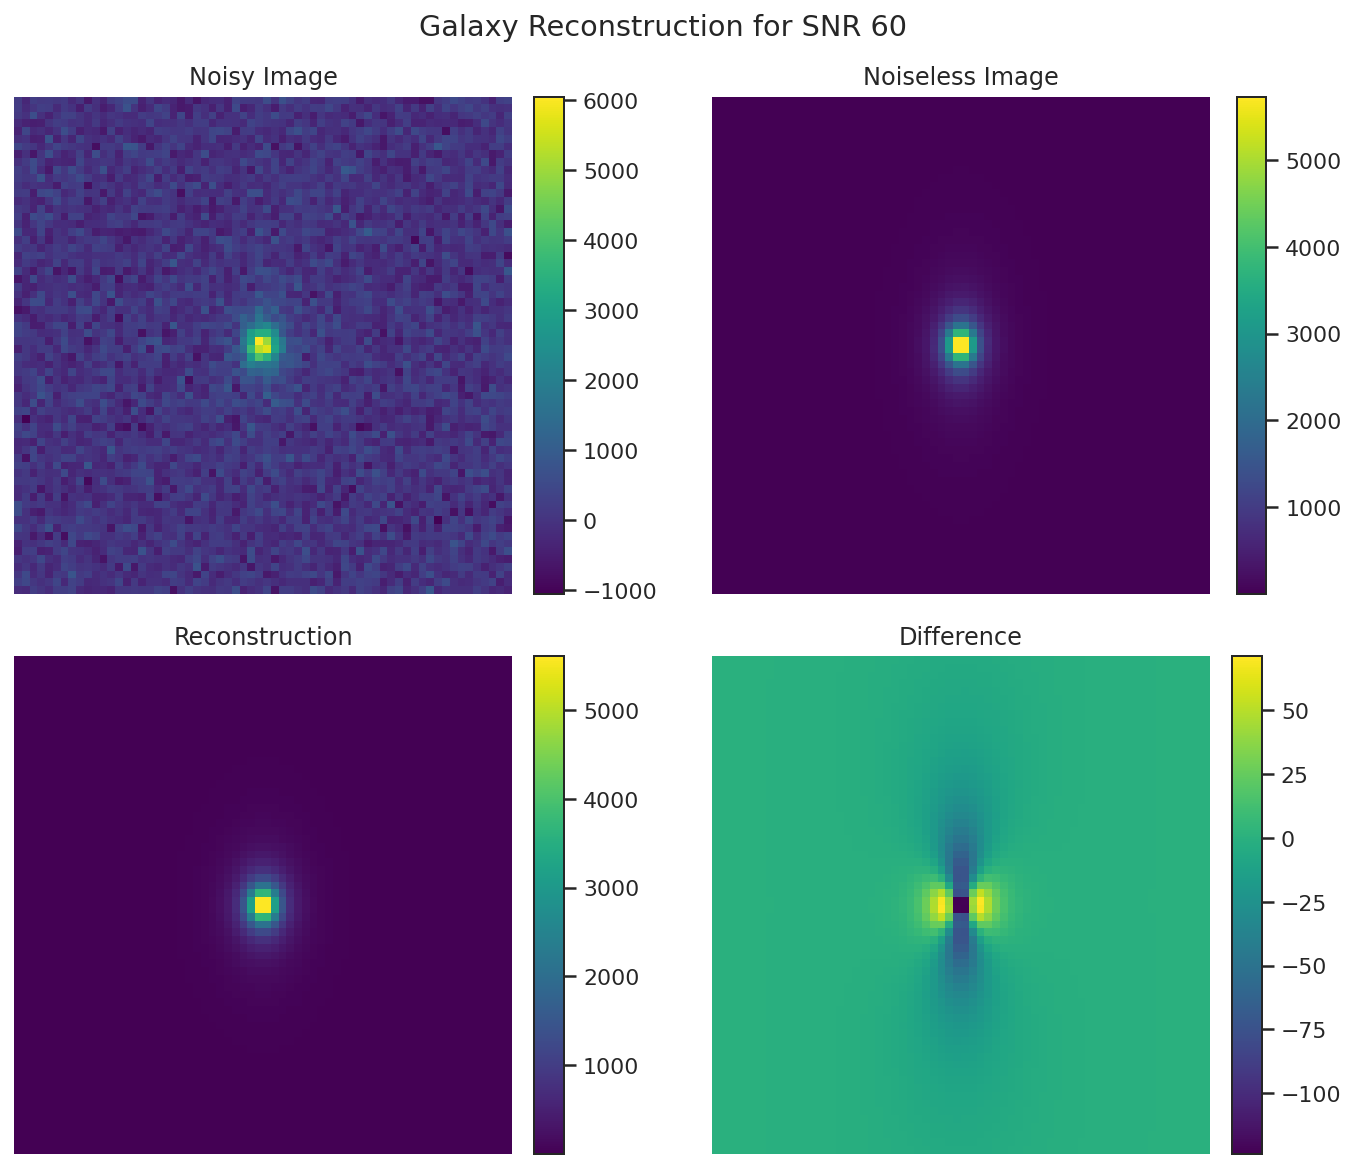

In [13]:
# Load the model and make predictions
r = load_xception(model_version=2)
model, scaler, X_val, y_val, noisy_val, noiseless_val, psf_r_val, sigma_val, snr_val = (
    r["model"],
    r["scaler"],
    r["X_val"],
    r["y_val"],
    r["noisy_val"],
    r["noiseless_val"],
    r["psf_r_val"],
    r["sigma_val"],
    r["snr_val"],
)
y_pred_normalized = model.predict(X_val)
y_pred = scaler.inverse_transform(y_pred_normalized)

# Pick a galaxy image with SNR 60
idx = np.flatnonzero((snr_val > 60 - 0.01) & (snr_val < 60 + 0.01))[0]

# Reconstruct an image using GalSim from estimated parameters
reconstructed = galsim_image(*y_pred[idx], psf_r_val[idx])

# Plot the results
plot_galsim_reconstruction(noisy_val[idx], noiseless_val[idx], reconstructed)

Even though the noiseless and the reconstructed images look very similar, there are in fact significant differences between the two, which matter. For instance, our model is substantially underestimating pixel intensity in the very center of the galaxy. In other words, the model is underestimating the Sérsic index. The remaining parameters are also somewhat off, but to a lesser degree:

In [14]:
# Show the error between the predicted and the true parameters
label_names = ["Flux", "Sérsic index", "Sérsic radius", "g1", "g2"]
pd.Series(y_pred[idx] - r["y_val"][idx], index=[f"Δ {l}" for l in label_names]).to_frame().T

Δ Flux  Δ Sérsic index  Δ Sérsic radius      Δ g1      Δ g2
0 -20401.34375       -1.230561        -0.083988  0.090861 -0.001649

Our autoencoder model produces its own reconstructed images, which we can analyze in a similar fashion:

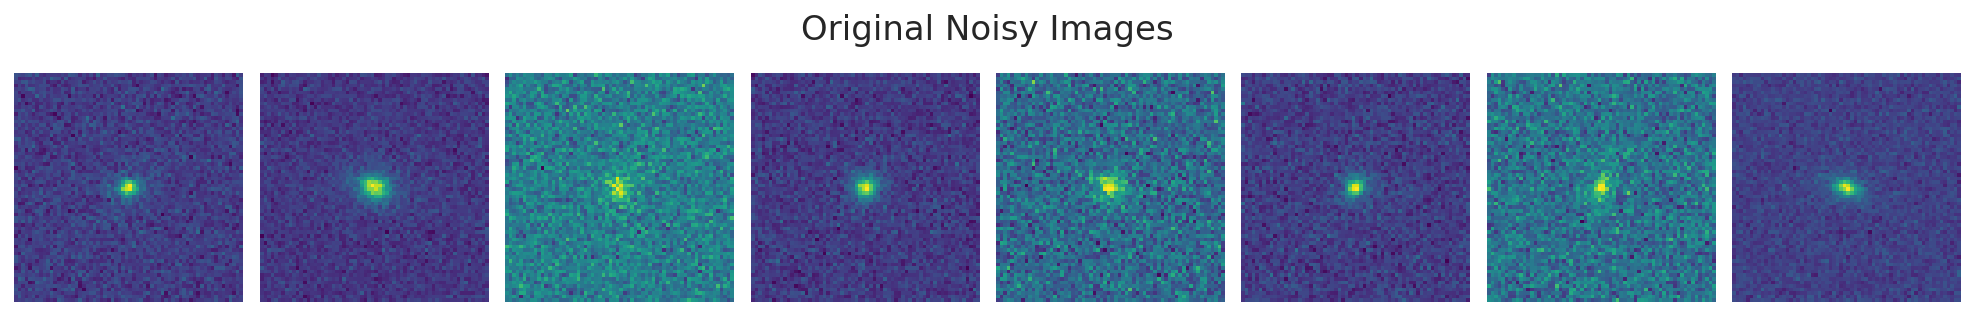

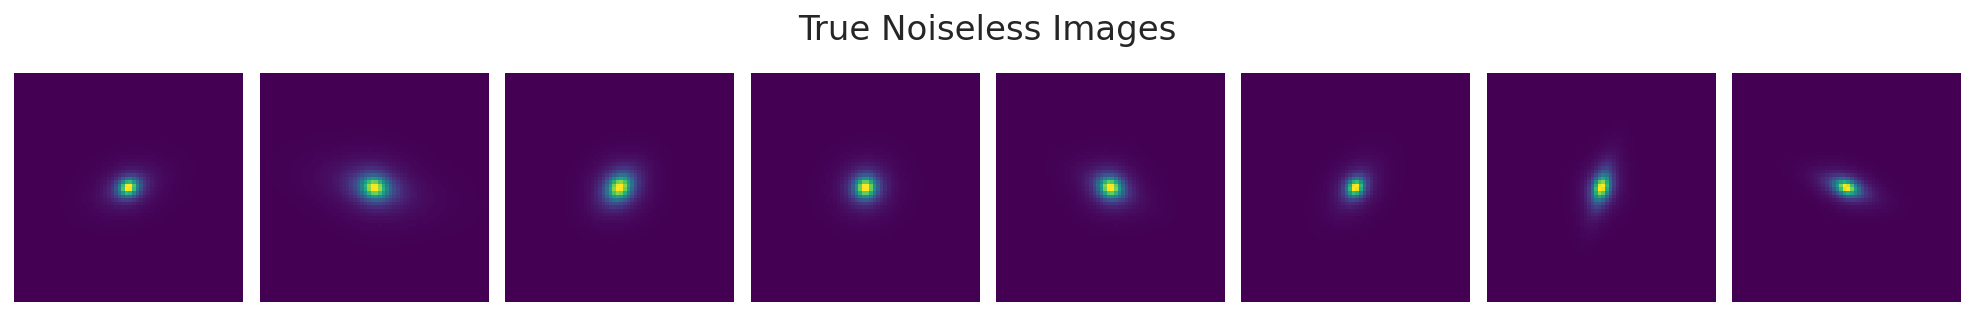

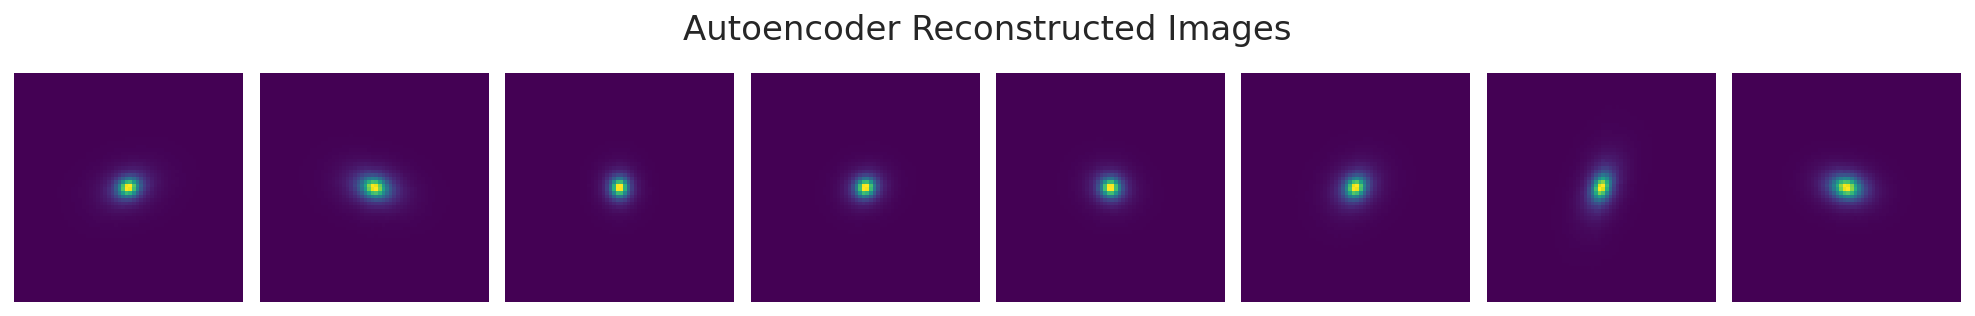

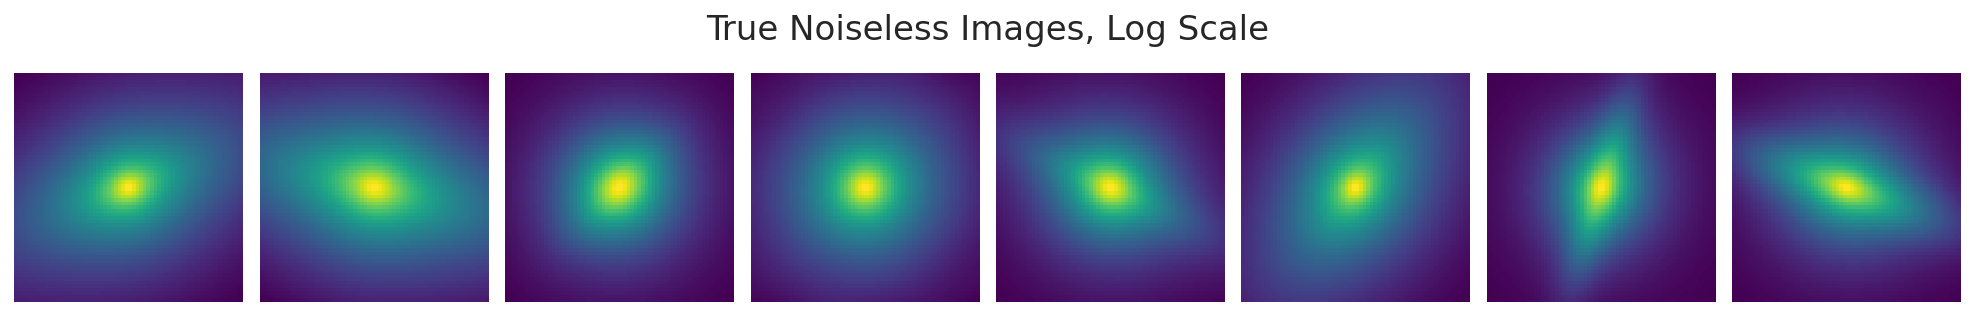

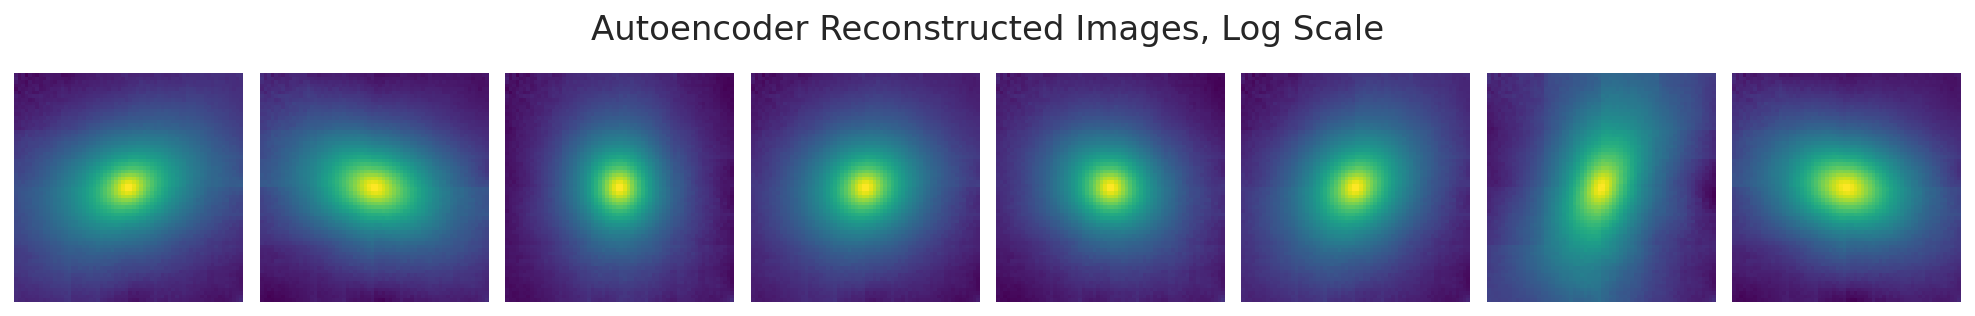

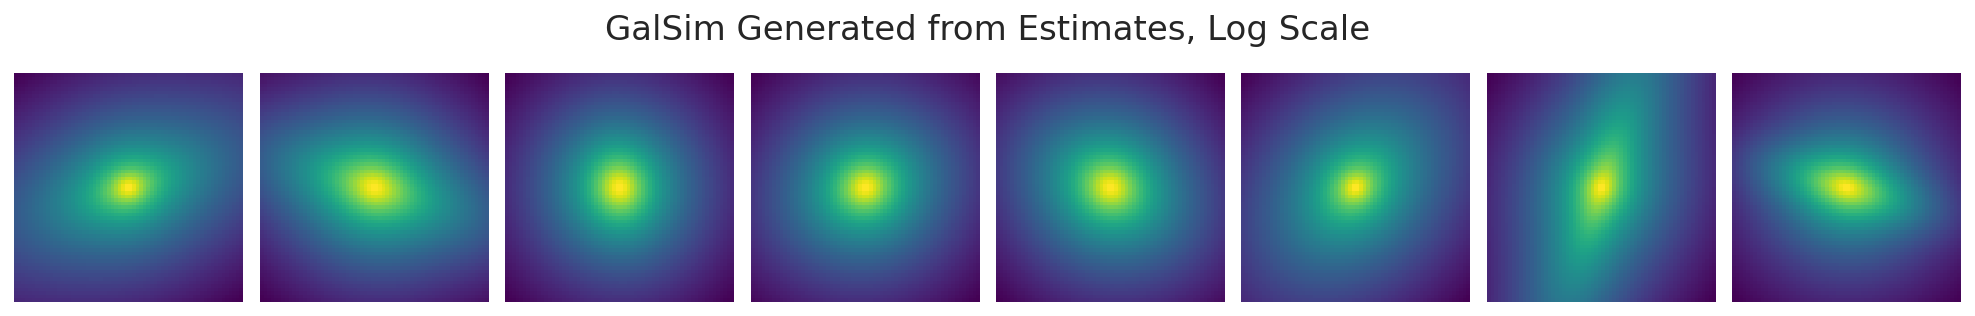

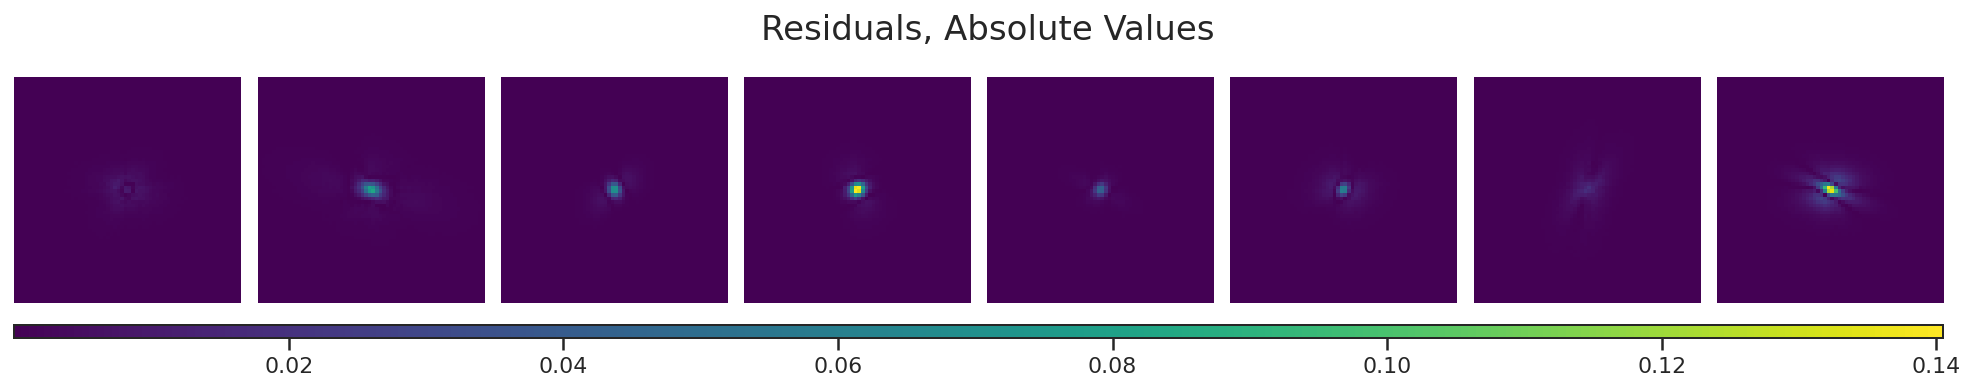

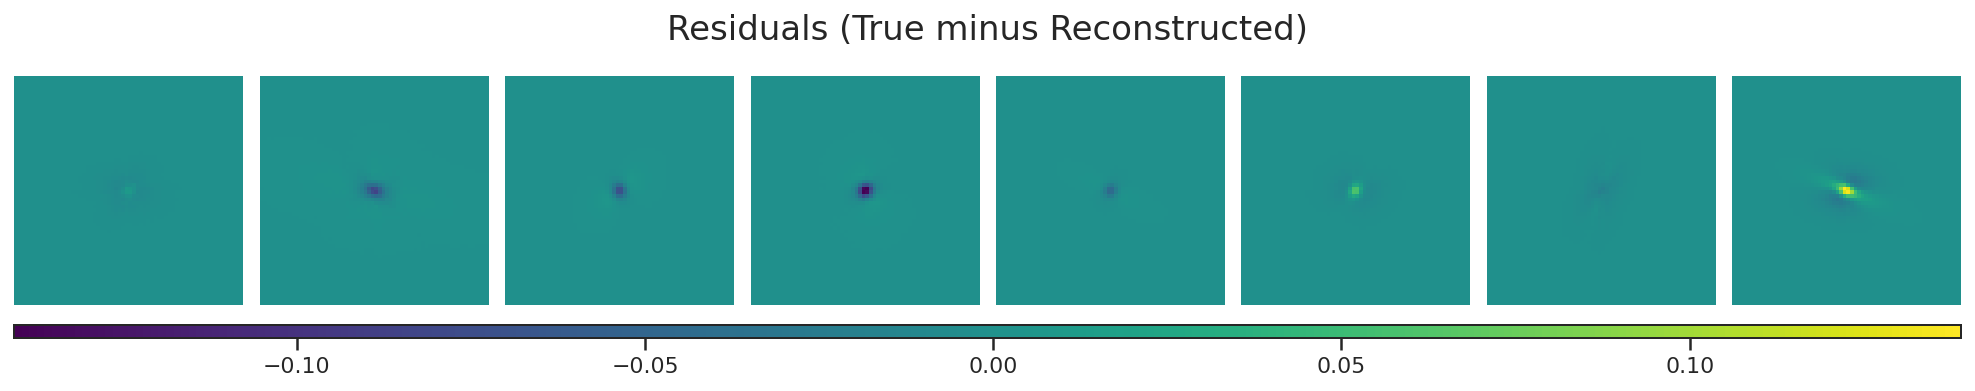

In [15]:
# Read the data set
data = load_data(set=3)

# Normalize the label, etc.
data["label_train"], data["label_val"], scaler3 = norm_label(data["label_train"], data["label_val"])
# Normalize the images
data["image_nonoise_train"], data["image_nonoise_val"], image_scaler3 = norm_image(
    data["image_nonoise_train"], data["image_nonoise_val"]
)
# Create a Tensorflow Dataset and pipeline
_, validation = create_dataset(data, set=3)
val_ds_AE = validation.map(pipeline_noisy_image_to_clean_image).batch(batch_size)

# Create Encoder, Decoder and Autoencoder
encoder = create_encoder(summary=False)
decoder = create_decoder(summary=False)
AE = create_AE(encoder, decoder, summary=False)

AE = train_or_load_AE(AE, set=3, train=train)

# 8 random indices for image visualization
idx = [200, 60, 194, 30, 85, 50, 165, 55]
generate_images(AE, val_ds_AE, idx, scaler3)

From a performance perspective, there are cases when the model does a reasonably good job of reconstructing the images. There are also situations where the differences are very apparent. Overall, we find that most of the error is concentrated in the center of the galaxy, as seen in the plots of residuals. Furthermore, we discover that the distortion is largely due to errors in parameter estimation, i.e. the encoder, as demonstrated by the plots on the log-scale.

We can also visualize the correspondence between the true and the estimated parameters across the whole validation set:

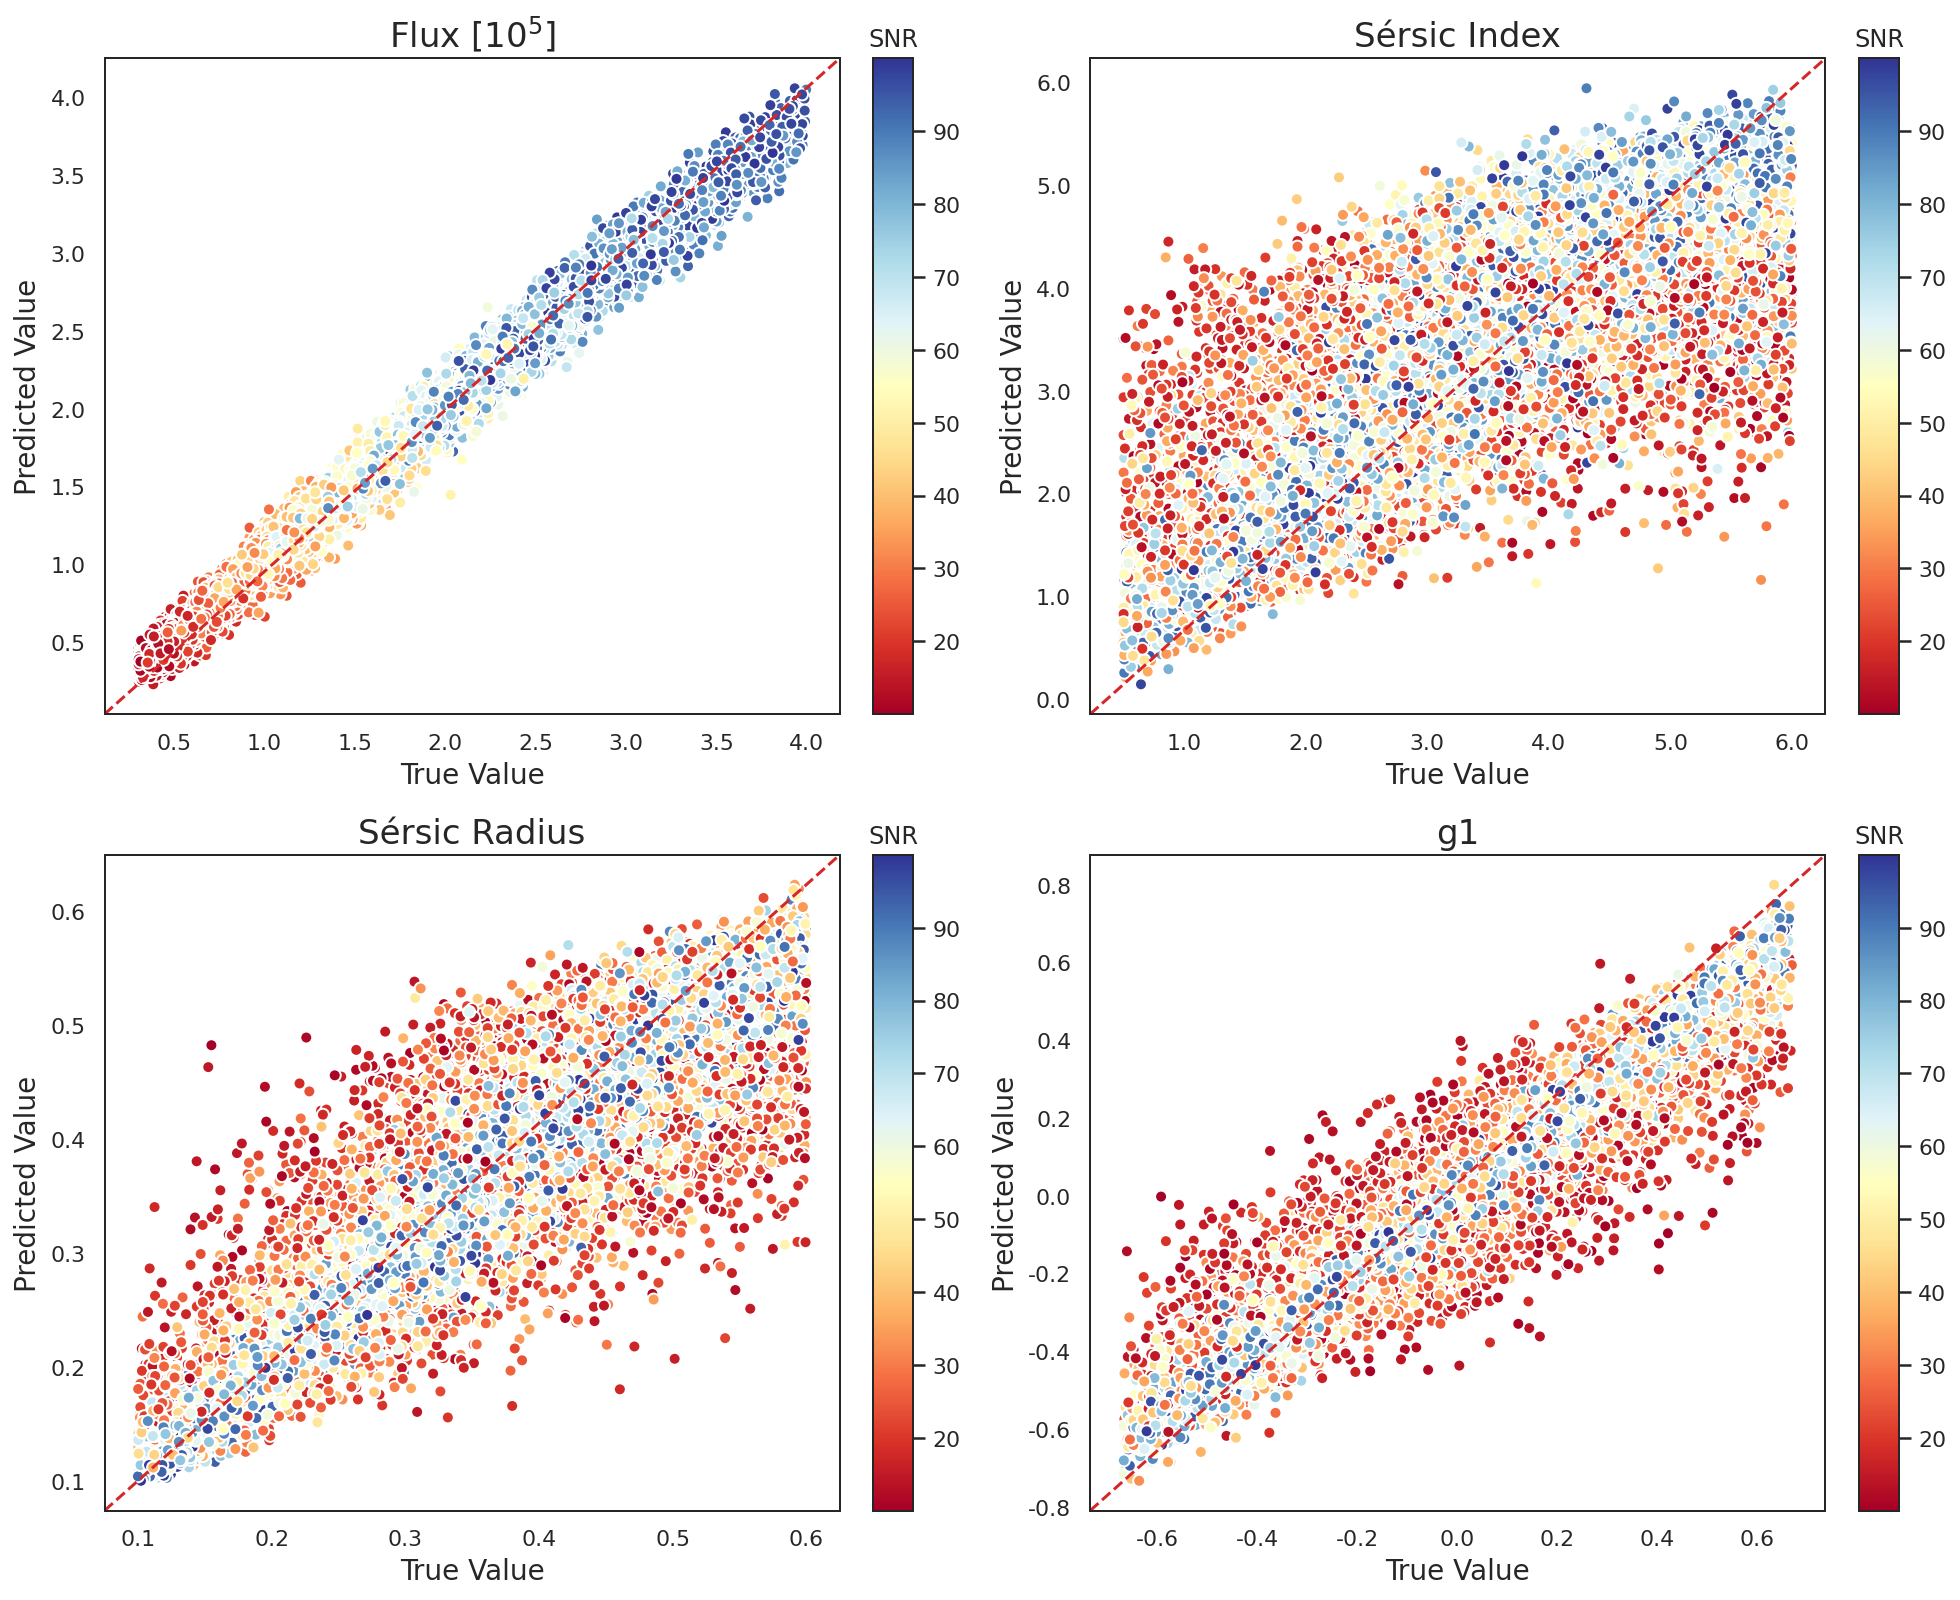

In [16]:
true_vs_pred(y_val, y_pred, snr_val)

Our model seems to have no difficulties estimating galaxy flux from noisy images. The deviation from a 45-degree line is minimal in the first plot. In addition to that, images with higher flux also have a higher signal-to-noise ratio. Still, the model is estimating almost the whole range of flux values equally well.

The correspondence between the true and the predicted values for the other parameters is much weaker. Especially problematic is the Sérsic index, which demonstrates the highest level of dispersion around the diagonal line. For all of these parameters there is a clear relationship between SNR and the precision of the estimates: the higher the signal-to-noise ratio, the better our model can estimate the parameter and vice versa.

To better understand the patterns in the errors, we will plot those against the true values:

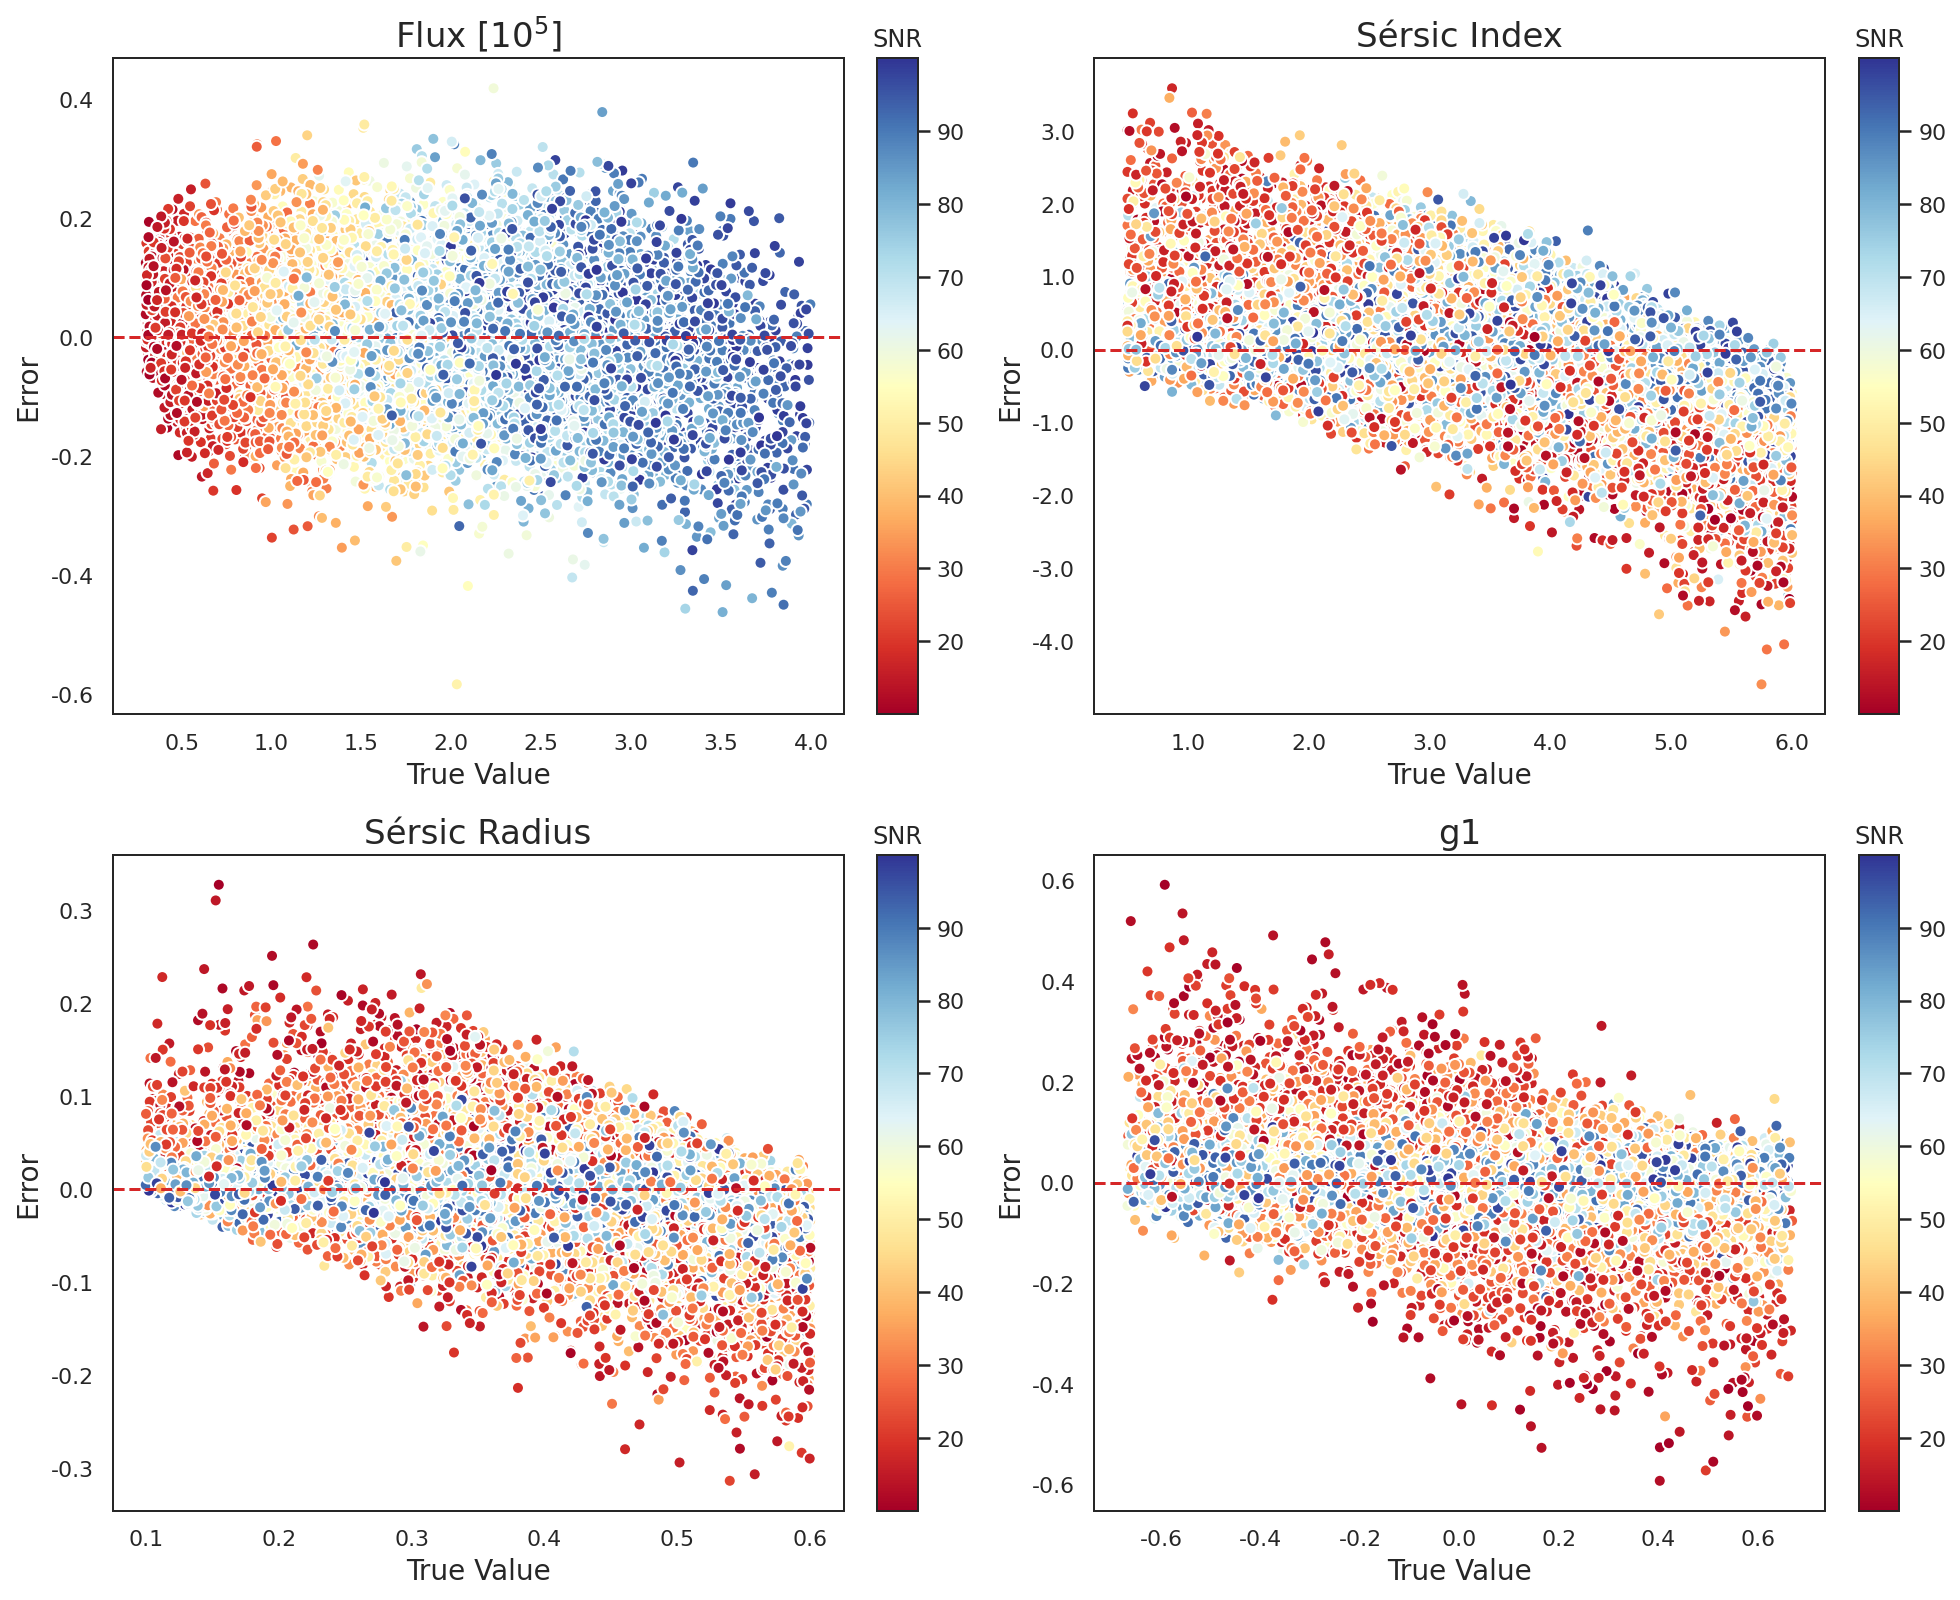

In [17]:
true_vs_error(y_val, y_pred, snr_val)

In the case of flux, there seems to be a slight tendency to underestimate the value of the parameter at the higher end of the spectrum. For the other parameters, we see a common trend: the parameters are overestimated at the lower values and underestimated at the higher values. This relationship is mainly visible for the images with low signal-to-noise ratios. It is much less pronounced for images with high SNR.

Overall, the distributions of errors vaguely resemble bell-like and mostly symmetric shapes, which are centered around zero. That, however, does not exclude the presence of systematic errors in particular regions of each parameter, as we've seen previously:

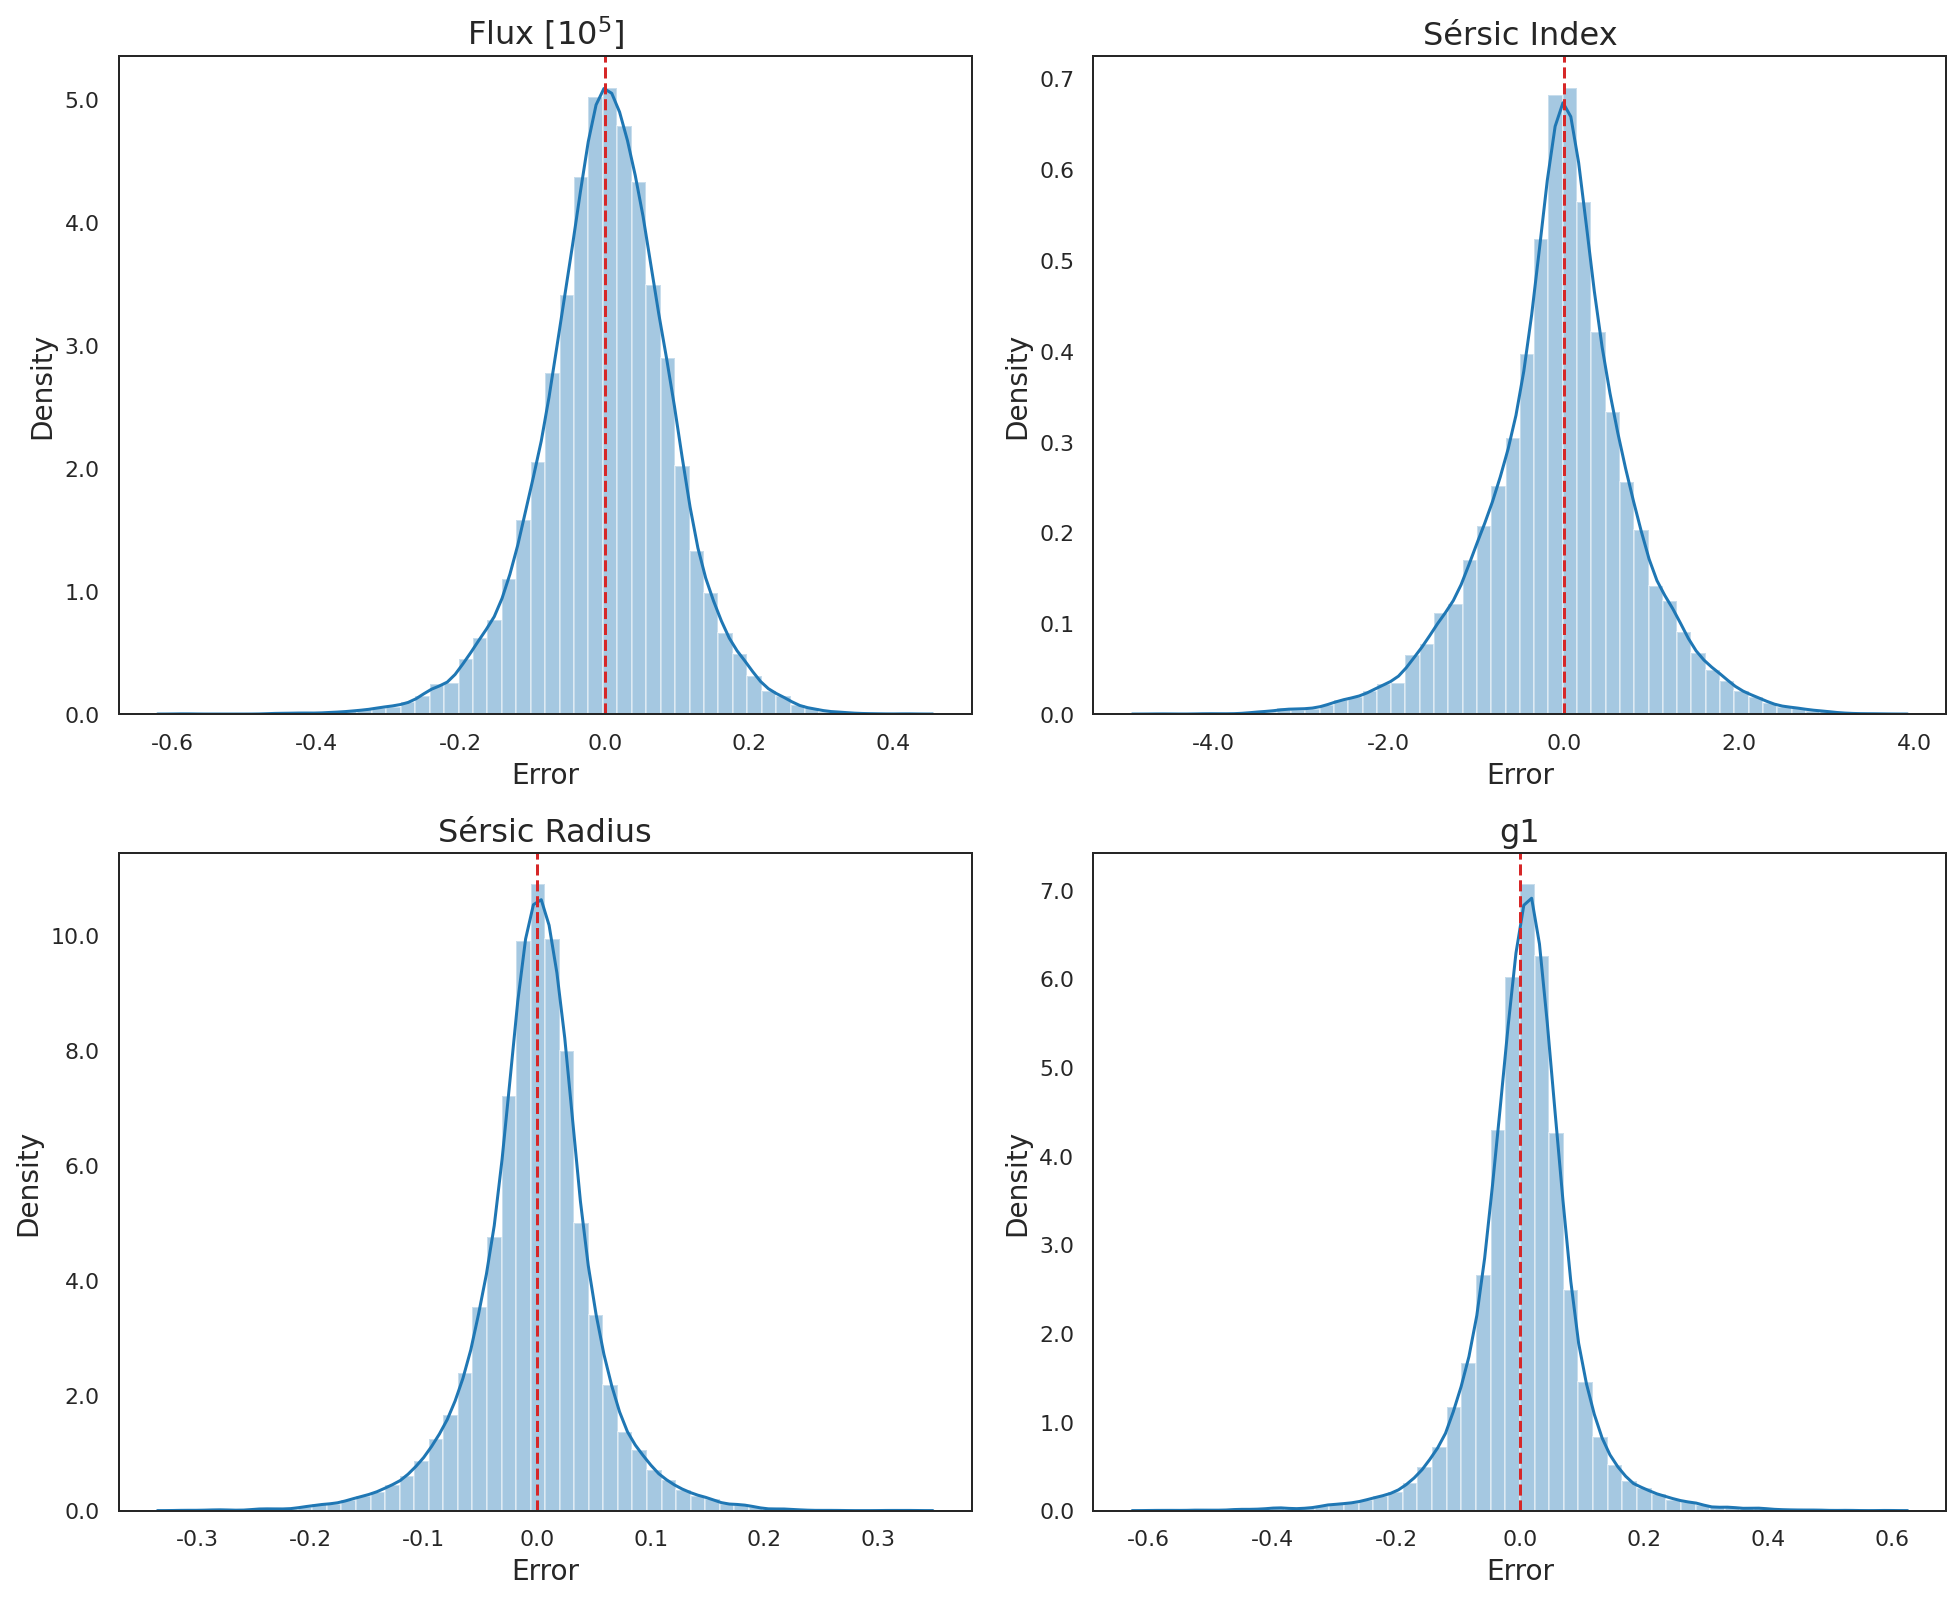

In [18]:
error_hist(y_val, y_pred)

### Benchmark against the Cramér–Rao bound (CRB)

So far our model evaluation was performed on the validation set. To get an additional insight into the performance of the models, we will use two separate test sets, generated with a fixed set of parameters:

| \# Samples | Avg. SNR | Flux [$10^5$] | Sérsic index | Sérsic radius | g1     | g2   | PSF  | Noise |
| ---------- | -------- | ------------- | ------------ | ------------- | ------ | ---- | ---- | ----- |
| 10,000     | 29.95    | 1.0           | 3.0          | 0.3           | -0.069 | 0.15 | 0.5  | 400   |
| 10,000     | 59.90    | 1.0           | 3.0          | 0.3           | -0.069 | 0.15 | 0.5  | 200   |

The images within each dataset differ only by the realizations of the noise. We will be computing the bias and the standard deviations for our two main models:

In [19]:
# Define the CRB and the baseline
label_names = ["Flux [10^5]", "Sérsic index", "Sérsic radius [arcsec]", "g1", "g2"]
crb = pd.DataFrame(
    [0.056, 0.78, 0.028, 0.054, 0.054, 0.11, 1.56, 0.056, 0.11, 0.11],
    index=pd.MultiIndex.from_product([["SNR 60", "SNR 30"], label_names]),
    columns=pd.MultiIndex.from_arrays([["Best Unbiased"], ["CRB"]]),
)

bias = [0.014, -0.168, 0.016, 0.015, -0.085, 0.017, -0.183, 0.044, 0.055, -0.184]
std = [0.120, 1.165, 0.063, 0.057, 0.087, 0.126, 2.307, 0.133, 0.132, 0.169]
baseline = pd.DataFrame(
    np.stack((bias, std), axis=1),
    index=pd.MultiIndex.from_product([["SNR 60", "SNR 30"], label_names]),
    columns=pd.MultiIndex.from_product([["Baseline Model"], ["Bias", "Std Dev"]]),
)

# Assess performance of Xception CNN
dfs = []
for snr in [60, 30]:
    # Load the data and the model
    X, y_true = load_testset(snr)
    model, scaler = load_xception_model(model_version=2)

    # Make predictions
    normalized_preds = model.predict(X)
    predictions = scaler.inverse_transform(normalized_preds)
    # Convert flux units to 10^5
    y_true[0] /= 1e5
    predictions[:, 0] /= 1e5

    bias = predictions.mean(axis=0) - y_true
    std = predictions.std(axis=0)

    df = pd.DataFrame(
        np.stack((bias, std), axis=1),
        index=pd.MultiIndex.from_product([[f"SNR {snr}"], label_names]),
        columns=pd.MultiIndex.from_product([["Xception CNN"], ["Bias", "Std Dev"]]),
    )
    dfs.append(df)

xception_metrics = pd.concat(dfs)

In [20]:
# Evaluate the autoencoder model
# Obtain the scalers
data = load_data(set=2)
_, _, scaler2 = norm_label(data["label_train"], data["label_val"])
_, _, image_scaler2 = norm_image(data["image_nonoise_train"], data["image_nonoise_val"])

dfs = []
for snr, dataset in zip([60, 30], [5, 4]):
    data = load_data(set=dataset, test=True)

    y_true = data["label_test"][0]
    y_true[0] /= 1e5

    # Normalize the labels
    data["label_test"] = norm_label(data["label_test"], scaler=scaler2)
    # Normalize the Images
    data["image_nonoise_test"] = norm_image(data["image_nonoise_test"], test=True, scaler=image_scaler2)

    testing = create_dataset(data, test=True)
    test_ds = testing.map(pipeline_noisy_image_to_clean_image).batch(batch_size)
    AE.load_weights(ae_paths[1])

    _, pred = AE.predict(test_ds)
    predictions = unnorm_label(pred, scaler2)
    predictions[:, 0] /= 1e5
    bias = predictions.mean(axis=0) - y_true
    std = predictions.std(axis=0)

    df = pd.DataFrame(
        np.stack((bias, std), axis=1),
        index=pd.MultiIndex.from_product([[f"SNR {snr}"], label_names]),
        columns=pd.MultiIndex.from_product([["Autoencoder"], ["Bias", "Std Dev"]]),
    )
    dfs.append(df)

autoencoder_metrics = pd.concat(dfs)

The resulting performance metrics on the test datasets look as follows:

In [21]:
pd.concat((crb, autoencoder_metrics, xception_metrics, baseline), axis=1).round(3)

Best Unbiased Autoencoder         Xception CNN  \
                                        CRB        Bias Std Dev         Bias   
SNR 60 Flux [10^5]                    0.056      -0.022   0.058        0.039   
       Sérsic index                   0.780       0.835   0.789        0.435   
       Sérsic radius [arcsec]         0.028       0.025   0.036        0.022   
       g1                             0.054       0.012   0.061        0.011   
       g2                             0.054       0.002   0.056       -0.013   
SNR 30 Flux [10^5]                    0.110       0.014   0.090        0.052   
       Sérsic index                   1.560       1.042   0.745        0.740   
       Sérsic radius [arcsec]         0.056       0.041   0.061        0.031   
       g1                             0.110      -0.020   0.102        0.013   
       g2                             0.110      -0.021   0.099       -0.024   

                                      Baseline Model          
                              Std Dev           Bias Std Dev  
SNR 60 Flux [10^5]              0.063          0.014   0.120  
       Sérsic index             0.765         -0.168   1.165  
       Sérsic radius [arcsec]   0.035          0.016   0.063  
       g1                       0.048          0.015   0.057  
       g2                       0.055         -0.085   0.087  
SNR 30 Flux [10^5]              0.098          0.017   0.126  
       Sérsic index             0.828         -0.183   2.307  
       Sérsic radius [arcsec]   0.060          0.044   0.133  
       g1                       0.091          0.055   0.132  
       g2                       0.100         -0.184   0.169

When we train a network, our objective is to minimize the loss on a validation dataset. However, this does not help us judge how close or far we are from the best results we can achieve. A neural network is nothing but a "function estimator", with multiple parameters, and our network is estimating 5 different parameters. We also know that the total variance of any unbiased estimator is bounded by the Cramér–Rao lower bound. Here we can see our results vis-a-vis this lower bound. 

Firstly, our estimator is biased, and in theory, the variance can be made smaller at the cost of increasing the bias. At the same time, our biases are mostly less than the standard deviation, and the standard deviations of our model's errors are very close to the Cramér-Rao bounds.

### Baseline Model

The purpose of the baseline model is to benchmark a new technique against a conventional one. In our case, the conventional approach is to carry out non-linear optimization for 5 parameters with the noisy galaxy image as the input.

We use `scipy.optimize.minimize` to perform optimization with `L-BFGS-B` algorithm. `Nelder-mead` & `BFGS` do not support bounds and lead to generation of "invalid" values of parameters during the minimization process when we use GalSim to produce model images.

The objective function we minimize takes the noisy image, iteratively generates new images using GalSim, and calculates the loss. We compute the loss as the (negative) log-likelihood of the Image given the current iteration of parameter values, i.e, the $\log$ of $P(Image | Parameters)$. We take the negative of this to get the minimization objective.<br>

Overall, the baseline model does a reasonable estimation and comes close to the Cramér-Rao bound. However, an iteration of minimization / parameter estimation takes about 35 seconds on JupyterHub, whereas the neural networks can process a million images in under 15 minutes. We include the code for the baseline model as part of our submission.

---

# Limitations

We need to consider the limitations of our model and the approach in general. Besides the demonstrated bias, which is significant for some of the parameters, the most important fact is that our models have been trained and evaluated on synthetic data:

- The limited range of values the models have been trained on might lead to unexpected or overconfident results outside of that range of values.
- Beyond the synthetic dataset, we currently do not have an understanding of the behavior of the model. Many questions remain open:
  - Can we train a model on synthetic data and expect at least some of the learning to be transferable to the images of real galaxies? What is the amount of covariate shift between the distributions of generated and real images?
  - If the models need to be retrained on real data, were would the labels for supervised learning be coming from? 
- Lastly, a neural network is inherently a black box tool. Compared to traditional estimation methods, deep learning algorithms might hinder the interpretation of results. This may be especially important for natural sciences. The networks might also be failing silently, without us even noticing that.

Eventually, our models are proof of concept, and the applicability to real-life astrophysical tasks needs to be thoroughly investigated.

---

# Future Work

We would like to conclude by outlining some of the directions for possible future research. This includes:

- **Grad-CAM and Saliency maps:** examining these may provide insights for improving the estimation of parameters like Sérsic Index and Sérsic Radius.
- **Attention layers:** focusing a network's attention on particular regions on the image might prove useful for estimating galaxy parameters.
- **Additional training:** can help improve the performance of some of our models.
- **Ensuring robustness:** by incorporating uncertainty into our point estimates using Bayesian or frequentist methods we can make sure that the models can safely be used on out-of-distribution data.
- **Real galaxy images:** training and testing on real data will demonstrate whether our proof-of-concept approach is applicable to actual astrophysical tasks.

---

# References

1. A. W. Graham, S. P. Driver, 2005, [A concise reference to (projected) Sersic $R^{1/n}$ quantities, including Concentration, Profile Slopes, Petrosian indices, and Kron Magnitudes](https://arxiv.org/pdf/astro-ph/0503176)
2. D. Tuccillo, M. Huertas-Company, E. Decencière, S. Velasco-Forero, H. Domínguez Sánchez, P. Dimauro, 2017, [Deep learning for galaxy surface brightness profile fitting](https://arxiv.org/pdf/1711.03108)
3. S. Madireddy, N. Li, N. Ramachandra, P. Balaprakash, S. Habib, 2019, [Modular Deep Learning Analysis of Galaxy-Scale Strong Lensing Images](https://arxiv.org/pdf/1911.03867)
4. François Chollet, 2017, [Xception: Deep Learning with Depthwise Separable Convolutions](https://arxiv.org/pdf/1610.02357)
4. Peter Erwin, 2014, [Imfit: A Fast, Flexible New Program for Astronomical Image Fitting](https://arxiv.org/pdf/1408.1097)
5. I. Breda, P. Papaderos, J. M. Gomes, S. Amarantidis, 2019, [A new fitting concept for the robust determination of Sérsic model parameters](https://arxiv.org/pdf/1910.07043)
6. B. Lim, S. Son, H. Kim, S. Nah, K. M. Lee, 2017, [Enhanced Deep Residual Networks for Single Image Super-Resolution](https://arxiv.org/pdf/1707.02921)
7. Y. Zhang, Y. Tian, Y. Kong, B. Zhong, Y. Fu, 2020, [Residual Dense Network for Image Restoration](https://arxiv.org/pdf/1812.10477)